In [58]:
import jax.numpy as jnp
import jax
import jax.scipy as jsp
import matplotlib.pyplot as plt

Let us generate some dummy data.

In [90]:
def generate(key, n, m):
    x_0 = jax.random.normal(key, (n, n))
    x_hist = jnp.zeros((m, n, n))

    window = jax.random.normal(key, (n, n))

    # diffuse the initial condition over time with random kernel
    x = x_0
    for i in range(m):
        x = x + 0.1 * jsp.signal.correlate(x, window, mode='same')
    
        x_hist = x_hist.at[i, :].set(x)

    # unsqueeze
    x_hist = x_hist.reshape((m, n, n, 1))

    return x_hist

n = 10
m = 50
key = jax.random.PRNGKey(0)
data = generate(key, n, m)

print(data.shape)

(50, 10, 10, 1)


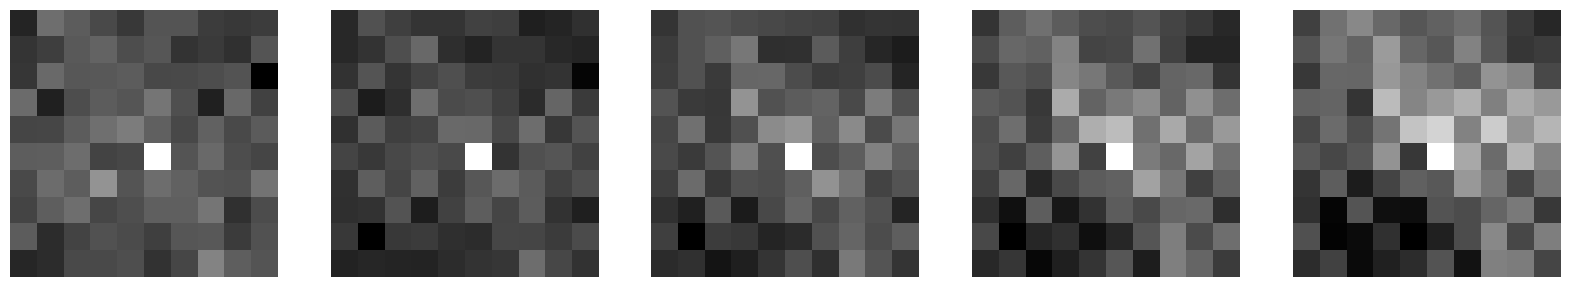

In [91]:
# generate 5 plots in a row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(data[i], cmap='gray')
    axs[i].axis('off')

In [92]:
from clu import metrics
from flax import linen as nn
from flax.training import train_state
from flax import struct
import optax

In [93]:
class Encoder(nn.Module):

    def setup(self):
        self.conv1 = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.Conv(features=128, kernel_size=(3, 3), strides=(2, 2))
    
    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)
        return x

In [87]:
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([n, n, 1]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

state = create_train_state(Encoder(), jax.random.PRNGKey(0), 1e-3, 0.9)

print(state.apply_fn(data[0]))
    

AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'items'

In [ ]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state


In [53]:
class Decoder(nn.Module):

    def setup(self):
        return
    
    def __call__(self, x):
        return x

In [62]:

class Encoder(nn.Module):

    def setup(self):
        self.conv1 = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.Conv(features=128, kernel_size=(3, 3), strides=(2, 2))
    
    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)
        return x
    
encoder = Encoder()
params = encoder.init(key, jnp.ones((10, 10, 10, 1)))

print(data[0].shape)
encoded = encoder.apply(params, data[0])
print(encoded.shape)

(10, 10)


ScopeParamShapeError: Initializer expected to generate shape (3, 3, 1, 32) but got shape (3, 3, 10, 32) instead for parameter "kernel" in "/conv1". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

In [ ]:
class EncoderDecoder(nn.Module):

    def setup(self):
        self.encoder = Encoder()
        self.decoder = Decoder()
        return
    
    def __call__(self, x):
        return self.decoder(self.encoder(x))